# Model skill plots
### This notebook generates relevant plots from the modelled crowsource-based impacts (from Notebook 4)

In [16]:
#Load pacakges
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
import datetime as dt
import cartopy.crs as ccrs

from climada.engine import Impact
from climada import CONFIG
import scClim as sc

data_dir = str(CONFIG.local_data.data_dir)
out_dir = str(CONFIG.local_data.out_dir)


In [17]:
# Define parameters
haz_var = 'crowd'               # hazard variable
exp_var = 'KGV'                 # Exposure: 'Kantonale Gebäudeversicherung'
impf = 'emp_emanuel'            # Emanuel-type (sigmoidal) impact function
impf_fit_type = "flex_noBias"   # Fit with flexible exponent and minimized bias
version = 27                    # Version 2.7 of the gridding

In [18]:
#Load crowdsourced reports
str_cols = ['OsVersion','AppVersion','Language','size_text','size_text_new']
crowd_data = pd.read_csv(f'{data_dir}/crowd-source/crowd_processed_paper.csv',
                         parse_dates=['time_dt','hailday'],dtype={v:str for v in str_cols})
crowd_data['hailday'] = crowd_data.hailday.dt.date # Convert datetime to date

In [19]:
# Load gridded crowd-sourced data
ds_haz = xr.open_dataset(f'{data_dir}/crowd-source/Reports_min25_2020+_V{version}.nc')
ds_haz

<xarray.Dataset>
Dimensions:                          (time: 169, chy: 226, chx: 354)
Coordinates:
  * time                             (time) datetime64[ns] 2020-08-01 ... 202...
  * chx                              (chx) int32 2484500 2485500 ... 2837500
  * chy                              (chy) int32 1073500 1074500 ... 1298500
    lon                              (chy, chx) float64 ...
    lat                              (chy, chx) float64 ...
Data variables:
    h_raw                            (time, chy, chx) float64 ...
    n_rep                            (time, chy, chx) float64 ...
    pop                              (time, chy, chx) float64 ...
    h_smooth                         (time, chy, chx) float64 ...
    n_rep_within_kernel              (time, chy, chx) float64 ...
    rep_density_within_kernel        (time, chy, chx) float64 ...
    rep_density_within_kernel_weigh  (time, chy, chx) float64 ...

In [20]:
frac_above40_28June = ((ds_haz.h_smooth.sel(time='2021-06-28')>40).sum()/(ds_haz.h_smooth>40).sum()).values.item()
print(f'Fraction of reports above 40mm occuring on June 28 2021: {frac_above40_28June:.2%}')

Fraction of reports above 40mm occuring on June 28 2021: 37.36%


In [4]:
# Load dataframes with modelled vs. reported impacts (from notebook 4)
imp_dfMDR = pd.read_csv(f"{data_dir}/crowd-source/imp_dfs/V{version}_MDR{impf_fit_type}.csv",
                        index_col=0)#,date_parser=['date'],infer_datetime_format=True)
imp_dfPAA = pd.read_csv(f"{data_dir}/crowd-source/imp_dfs/V{version}_PAA{impf_fit_type}.csv",
                        index_col=0)

In [21]:
#Define function to convert impact dataframes to xarray dataset (for plotting)
def get_ds_from_imp_df(imp_dfMDR,imp_dfPAA):
    imp_merged = pd.merge(imp_dfMDR,imp_dfPAA,
                          on='date',how='outer',suffixes=('_MDR','_PAA'))
    imp_merged = imp_merged.rename({'imp_obs_PAA':'n_count',
                                    'imp_obs_MDR':'imp_observed',
                                    'imp_modelled_PAA':'n_count_mod',
                                    'imp_modelled_MDR':'imp_mod',},axis=1)
    imp_ds = xr.Dataset.from_dataframe(imp_merged.set_index('date'))
    if imp_ds.date.dtype =='object':
        imp_ds['date'] = pd.to_datetime(imp_ds.date)
    return imp_ds

#Convert impact dataframes to xarray dataset
imp_ds = get_ds_from_imp_df(imp_dfMDR,imp_dfPAA)
imp_ds['n_count'] = imp_ds.n_count.fillna(0)
imp_ds

<xarray.Dataset>
Dimensions:       (date: 157)
Coordinates:
  * date          (date) datetime64[ns] 2020-08-01 2020-08-02 ... 2023-09-22
Data variables:
    imp_mod       (date) float64 186.6 19.82 0.0 296.6 ... 0.0 0.0 1.328e+04
    imp_observed  (date) float64 1.855e+04 5.66e+03 ... 3.208e+04 5.853e+03
    n_count_mod   (date) float64 0.67 0.2192 0.0 0.6329 ... 86.47 nan 0.0 11.37
    n_count       (date) float64 8.0 2.0 4.0 7.0 58.0 ... 0.0 106.0 0.0 5.0 2.0

In [22]:
# Load gridded exposure and damage data from KGV (Kantonale Gebäudeversicherung)
ds_KGV = xr.open_dataset(data_dir+'/KGV/ds_building_dmg_v71_1000m_wModImp.nc')
ds_KGV = ds_KGV.rename({'value':'imp_observed'})

#ThHe data also included modelled MESHS-based impacts. Define the PAA and MDR
ds_KGV['PAA_MESHS'] = ds_KGV.n_buildings_MESHS/ds_KGV.n_count_exposure
ds_KGV['MDR_MESHS'] = ds_KGV.imp_MESHS/ds_KGV.value_exposure
#Round the number of buildings and monetary values to integer values
ds_KGV[['n_buildings_MESHS','imp_MESHS']] = ds_KGV[['n_buildings_MESHS','imp_MESHS']].round(0)

#Spatially aggregate data
ds_KGV_per_event = ds_KGV.sum(dim=['chx','chy'])
per_event_from21 = ds_KGV_per_event.sel(date=slice('2020-08-01','2023-09-30'))

In [23]:
#Load impact matrix data and add it to the spatial dataset
imp = Impact.from_hdf5(f"{data_dir}/crowd-source/imp_dfs/V{version}_MDR{impf_fit_type}.hdf5")
imp_PAA = Impact.from_hdf5(f"{data_dir}/crowd-source/imp_dfs/V{version}_PAA{impf_fit_type}.hdf5")

ds_KGV = sc.both.add_imp_to_xr(imp,ds_KGV,varname='imp_crowd')
ds_KGV = sc.both.add_imp_to_xr(imp_PAA,ds_KGV,varname='n_count_crowd')
ds_KGV['PAA_crowd'] = ds_KGV.n_count_crowd/ds_KGV.n_count_exposure
ds_KGV['MDR_crowd'] = ds_KGV.imp_crowd/ds_KGV.value_exposure

#### Skill per Canton

In [24]:
#create meshgrid from ds_KGV chx and chy
chx_mesh,chy_mesh = np.meshgrid(ds_KGV.chx.values,ds_KGV.chy.values)
gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(chx_mesh.flatten(),chy_mesh.flatten()),crs=ccrs.epsg(2056))

#Load canton shapefile
cantons = gpd.read_file(f"{str(CONFIG.ch_shp_path)}/swissTLMRegio_KANTONSGEBIET_LV95.shp").to_crs(epsg=2056)


#Select the gridpoints (chx, chy) within the selected canton zürich
canton_list = ['Zürich','Bern','Luzern','Aargau']
canton_list_EN = ['Zurich','Berne','Lucerne','Aargau']
color_list = ['blue','green','lightblue','lightgreen']
for canton in canton_list:
    gdf_zh = gpd.sjoin(gdf,cantons[cantons.NAME==canton],predicate='within')
    gdf[f'in_{canton}'] = gdf.index.isin(gdf_zh.index)
    in_canton_2d = np.reshape(gdf[f'in_{canton}'].values,chx_mesh.shape)
    ds_KGV[f'in_{canton}'] = xr.DataArray(in_canton_2d,dims=['chy','chx'])


In [25]:
#Define plotting parameters
#Row 1: ------aggregated data. (1st: Crowdsourced, 2nd: Radar-based)-----------
colors= ['purple','green']
markers = ['^','o']
labels = ["Crowdsourced","Radar-based"]
handles = [Line2D([], [], color=colors[i],marker=markers[i], lw=0, label=label) for i,label in enumerate(labels)]

#Row 2: ------------------------- Data per canton ----------------------------
kwarg_list = [{"year_colors":[],"marker":markers[0],"ec":"black","zorder":5},
              {"year_colors":[],"marker":markers[1],"ec":"grey"}]

color_list = ['tab:blue','tab:orange','tab:green','tab:purple']
handles2 = [Line2D([], [], color='black',marker=markers[i], lw=0, label=label) for i,label in enumerate(labels)]
handles2 = handles2 + [Patch(facecolor=color_list[i],label=canton) for i,canton in enumerate(canton_list)]

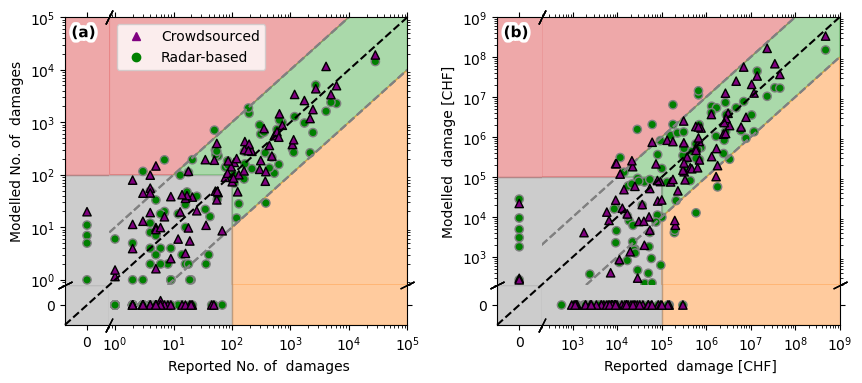

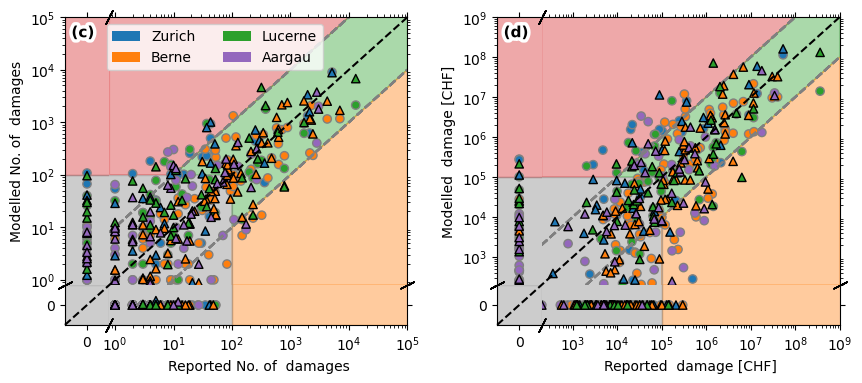

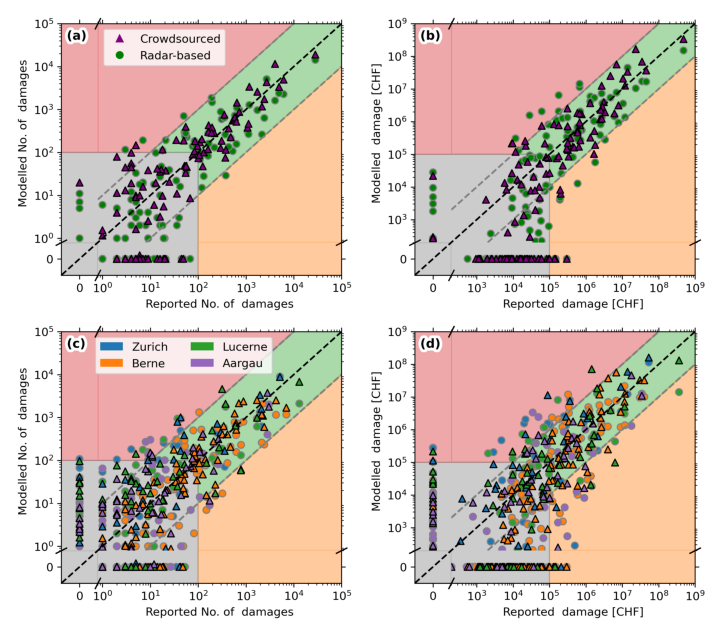

In [ ]:
#Row 1: ----------------------aggregated data--------------------------------
#Plot Crowdsourced data
fig,axes = sc.plot_funcs.plot_skill_plot(
    imp_ds,PAA_lim=(0.8,1e5),MDR_lim=(200,1e9),year_colors=[],
    imp_mod_names=["n_count_mod","imp_mod"],unique_color=colors[0],ret_ax=True,
    marker=markers[0],zorder=5
    )

#Add Radar-based data
fig = sc.plot_funcs.plot_skill_plot(
    per_event_from21,PAA_lim=(0.8,1e5),MDR_lim=(200,1e9),unique_color=colors[1],
    year_colors=[],gs_fig=(axes,fig),marker=markers[1],ec='grey', labels=["(a)","(b)"]
    )

#Add legend
fig.legend(handles, labels, loc='upper left',ncol=1,bbox_to_anchor=(0.17,0.88))


#Row 2: ------------------------- Data per canton ----------------------------
for canton,col in zip(canton_list,color_list):
    #Select data for the canton
    ds_canton_per_event = ds_KGV.where(ds_KGV[f"in_{canton}"]).sum(dim=['chx','chy'])
    ds_canton_per_event = ds_canton_per_event.sel(date=slice('2020-08-01','2023-09-30'))

    #make dataframe to store all canton's values
    imp_temp = ds_canton_per_event[['n_count','imp_observed',
                                    'n_count_crowd','imp_crowd',
                                    'n_buildings_MESHS','imp_MESHS']].to_dataframe()
    if canton == canton_list[0]:
        imp_df_canton = imp_temp.copy()
    else:
        imp_df_canton = pd.concat([imp_df_canton,imp_temp])

    #Loop over 2 options: crowdsourced and radar-based
    for imp_mod_names,kwargs in zip([["n_count_crowd","imp_crowd"],None],
                                        kwarg_list):

        #Plot the scatter plot of modelled vs. observed impacts
        if canton == canton_list[0] and imp_mod_names is not None: #first iteration
            fig2,axes2 = sc.plot_funcs.plot_skill_plot(ds_canton_per_event,imp_mod_names=imp_mod_names,
                                                     PAA_lim=(0.8,1e5),unique_color=col, labels=["(c)","(d)"],
                                                MDR_lim=(200,1e9),ret_ax=True,**kwargs)
        else:
            fig2 = sc.plot_funcs.plot_skill_plot(ds_canton_per_event,imp_mod_names=imp_mod_names,
                                                PAA_lim=(0.8,1e5),unique_color=col,
                                                MDR_lim=(200,1e9),gs_fig=(axes2,fig2),**kwargs)

#Add legend
fig2.legend(handles2[2:], canton_list_EN, loc='upper left',ncol=2,bbox_to_anchor=(0.16,0.88))

# Save individual figures
fig.savefig(f"{out_dir}/explorative/crowd/skill/overall_V{version}_{impf_fit_type}.png", dpi=300, bbox_inches='tight')
fig2.savefig(f"{out_dir}/explorative/crowd/skill/canton_V{version}_{impf_fit_type}.png", dpi=300, bbox_inches='tight')

# Create a combined figure
fig_combined = plt.figure(figsize=(10, 8))
gs = GridSpec(2, 1, height_ratios=[1, 1], hspace=0)

# Add the first figure (overall skill)
ax1 = fig_combined.add_subplot(gs[0])
img1 = plt.imread(f"{out_dir}/explorative/crowd/skill/overall_V{version}_{impf_fit_type}.png")
ax1.imshow(img1)
ax1.axis('off')

# Add the second figure (per-canton skill)
ax2 = fig_combined.add_subplot(gs[1])
img2 = plt.imread(f"{out_dir}/explorative/crowd/skill/canton_V{version}_{impf_fit_type}.png")
ax2.imshow(img2)
ax2.axis('off')

# Save the combined figure
fig_combined.savefig(f"{out_dir}/paper_crowd/skill_combined.png", dpi=300, bbox_inches='tight')

## Skill metrics


In [26]:
#Skill metrics and total damages per canton
for i,canton in enumerate(canton_list):
    ds_now = ds_KGV.where(ds_KGV[f"in_{canton}"]).sum(dim=['chx','chy'])
    ds_now = ds_now.sel(date=slice('2020-08-01','2023-09-30'))
    imp_df_now = ds_now.to_dataframe()
    rmse,rmsf,rmsf_weighted,FAR,POD,p_within_OOM,n_ev = sc.E.calc_skill_scores(
        imp_df_now,dmg_thresh=1e2,imp_modelled='n_count_crowd',imp_obs='n_count')
    print(f"{canton}: Fraction of hits (PAA): {p_within_OOM:.1%}, FAR:{FAR:.1%}, POD:{POD:.1%},n_ev:{n_ev}")
    rmse,rmsf,rmsf_weighted,FAR,POD,p_within_OOM,n_ev = sc.E.calc_skill_scores(
        imp_df_now,dmg_thresh=1e5,imp_modelled='imp_crowd',imp_obs='imp_observed')
    print(f"{canton}: Fraction of hits (MDR): {p_within_OOM:.1%}, FAR:{FAR:.1%}, POD:{POD:.1%}, n_ev:{n_ev}")
    tot_frac_PAA = ds_now.n_count_crowd.sum()/ds_now.n_count.sum()
    tot_frac_MDR = ds_now.imp_crowd.sum()/ds_now.imp_observed.sum()
    tot_frac_PAA_MESHS = ds_now.n_buildings_MESHS.sum()/ds_now.n_count.sum()
    tot_frac_MDR_MESHS = ds_now.imp_MESHS.sum()/ds_now.imp_observed.sum()
    print(f"Total fraction of damages in {canton} from PAA: {tot_frac_PAA:.2%}, MDR: {tot_frac_MDR:.2%}")
    # print(f"Total fraction of damages in {canton} from PAA MESHS: {tot_frac_PAA_MESHS:.2%}, MDR MESHS: {tot_frac_MDR_MESHS:.2%}")

Zürich: Fraction of hits (PAA): 75.0%, FAR:25.0%, POD:100.0%,n_ev:12
Zürich: Fraction of hits (MDR): 52.9%, FAR:30.8%, POD:64.3%, n_ev:17
Total fraction of damages in Zürich from PAA: 166.59%, MDR: 322.36%
Bern: Fraction of hits (PAA): 96.7%, FAR:0.0%, POD:96.2%,n_ev:30
Bern: Fraction of hits (MDR): 80.9%, FAR:0.0%, POD:80.9%, n_ev:47
Total fraction of damages in Bern from PAA: 73.38%, MDR: 161.53%
Luzern: Fraction of hits (PAA): 61.5%, FAR:30.0%, POD:70.0%,n_ev:13
Luzern: Fraction of hits (MDR): 66.7%, FAR:25.0%, POD:73.3%, n_ev:21
Total fraction of damages in Luzern from PAA: 94.83%, MDR: 59.27%
Aargau: Fraction of hits (PAA): 72.7%, FAR:22.2%, POD:85.7%,n_ev:11
Aargau: Fraction of hits (MDR): 66.7%, FAR:7.1%, POD:62.5%, n_ev:21
Total fraction of damages in Aargau from PAA: 103.89%, MDR: 106.76%


In [33]:
#calculate skill measures
rmse,rmsf,rmsf_weighted,FAR,POD,p_within_OOM,n_ev = sc.E.calc_skill_scores(
    imp_dfPAA,dmg_thresh=1e2)
p_within_OOM
print(f"Fraction of hits: {p_within_OOM:.1%}")

Fraction of hits: 97.7%


In [27]:
#Create impact dataframes for MESHS-based impacts and crowdsourced impacts
PAA_thresh = 1e2
MDR_thresh = 1e5

imp_df_MESHS =  per_event_from21[['n_count','n_buildings_MESHS','imp_observed','imp_MESHS']].to_dataframe()
imp_df_crowd = imp_ds.to_dataframe()

In [28]:
#Calculate and print skill scores
rmse,rmsf,rmsf_weighted,FAR,POD,p_within_OOM,n_ev = sc.E.calc_skill_scores(
    imp_df_crowd,dmg_thresh=1e2,imp_modelled='n_count_mod',imp_obs='n_count')
print(f"Fraction of hits (PAA, crowd): {p_within_OOM:.1%}, n_ev: {n_ev}")
rmse,rmsf,rmsf_weighted,FAR,POD,p_within_OOM,n_ev = sc.E.calc_skill_scores(
    imp_df_MESHS,dmg_thresh=1e2,imp_modelled='n_buildings_MESHS',imp_obs='n_count')
print(f"Fraction of hits (PAA, MESHS): {p_within_OOM:.1%}, n_ev: {n_ev}")

#monetary damages
rmse,rmsf,rmsf_weighted,FAR,POD,p_within_OOM,n_ev = sc.E.calc_skill_scores(
    imp_df_crowd,dmg_thresh=1e5,imp_modelled='imp_mod',imp_obs='imp_observed')
print(f"Fraction of hits (MDR, crowd): {p_within_OOM:.1%}, n_ev: {n_ev}")
rmse,rmsf,rmsf_weighted,FAR,POD,p_within_OOM,n_ev = sc.E.calc_skill_scores(
    imp_df_MESHS,dmg_thresh=1e5,imp_modelled='imp_MESHS',imp_obs='imp_observed')
print(f"Fraction of hits (MDR, MESHS): {p_within_OOM:.1%}, n_ev: {n_ev}")

Fraction of hits (PAA, crowd): 97.7%, n_ev: 43
Fraction of hits (PAA, MESHS): 91.5%, n_ev: 47
Fraction of hits (MDR, crowd): 77.4%, n_ev: 62
Fraction of hits (MDR, MESHS): 72.1%, n_ev: 61


In [ ]:
#Fraction of hits per canton
rmse,rmsf,rmsf_weighted,FAR,POD,p_within_OOM,n_ev = sc.E.calc_skill_scores(
    imp_df_canton,dmg_thresh=1e2,imp_modelled='n_count_crowd',imp_obs='n_count')
print(f"Per-canton fraction of hits (PAA, crowd): {p_within_OOM:.1%}, n_ev: {n_ev}")
rmse,rmsf,rmsf_weighted,FAR,POD,p_within_OOM,n_ev = sc.E.calc_skill_scores(
    imp_df_canton,dmg_thresh=1e2,imp_modelled='n_buildings_MESHS',imp_obs='n_count')
print(f"Per-canton fraction of hits (PAA, MESHS): {p_within_OOM:.1%}, n_ev: {n_ev}")
rmse,rmsf,rmsf_weighted,FAR,POD,p_within_OOM,n_ev = sc.E.calc_skill_scores(
    imp_df_canton,dmg_thresh=1e5,imp_modelled='imp_crowd',imp_obs='imp_observed')
print(f"Per-canton fraction of hits (MDR, crowd): {p_within_OOM:.1%}, n_ev: {n_ev}")
rmse,rmsf,rmsf_weighted,FAR,POD,p_within_OOM,n_ev = sc.E.calc_skill_scores(
    imp_df_canton,dmg_thresh=1e5,imp_modelled='imp_MESHS',imp_obs='imp_observed')
print(f"Per-canton fraction of hits (MDR, MESHS): {p_within_OOM:.1%}, n_ev: {n_ev}")

Per-canton fraction of hits (PAA, crowd): 81.8%, n_ev: 66
Per-canton fraction of hits (PAA, MESHS): 71.4%, n_ev: 77
Per-canton fraction of hits (MDR, crowd): 70.8%, n_ev: 106
Per-canton fraction of hits (MDR, MESHS): 58.0%, n_ev: 119


In [ ]:
#Total damages per individual canton
for i,canton in enumerate(canton_list):
    ds_now = ds_KGV.where(ds_KGV[f"in_{canton}"]).sum(dim=['chx','chy'])
    ds_now = ds_now.sel(date=slice('2020-08-01','2023-09-30'))
    imp_df_now = ds_now.to_dataframe()
    rmse,rmsf,rmsf_weighted,FAR,POD,p_within_OOM,n_ev = sc.E.calc_skill_scores(
        imp_df_now,dmg_thresh=PAA_thresh,imp_modelled='n_count_crowd',imp_obs='n_count')
    print(f"{canton}: Fraction of hits (PAA): {p_within_OOM:.1%}, FAR:{FAR:.1%}, POD:{POD:.1%},n_ev:{n_ev}")
    rmse,rmsf,rmsf_weighted,FAR,POD,p_within_OOM,n_ev = sc.E.calc_skill_scores(
        imp_df_now,dmg_thresh=MDR_thresh,imp_modelled='imp_crowd',imp_obs='imp_observed')
    print(f"{canton}: Fraction of hits (MDR): {p_within_OOM:.1%}, FAR:{FAR:.1%}, POD:{POD:.1%}, n_ev:{n_ev}")
    tot_frac_PAA = ds_now.n_count_crowd.sum()/ds_now.n_count.sum()
    tot_frac_MDR = ds_now.imp_crowd.sum()/ds_now.imp_observed.sum()
    tot_frac_PAA_MESHS = ds_now.n_buildings_MESHS.sum()/ds_now.n_count.sum()
    tot_frac_MDR_MESHS = ds_now.imp_MESHS.sum()/ds_now.imp_observed.sum()

    #Get the modelled to observed ratio
    _=sc.E.get_mod_obs_ratio(imp_df_now,PAA_thresh=100,MDR_thresh=1e5,imp_mod='imp_crowd',imp_PAA_mod='n_count_crowd',plot=False)
    print(f"Total fraction of damages in {canton} from PAA: {tot_frac_PAA:.2%}, MDR: {tot_frac_MDR:.2%}")

Zürich: Fraction of hits (PAA): 75.0%, FAR:25.0%, POD:100.0%,n_ev:12
Zürich: Fraction of hits (MDR): 52.9%, FAR:30.8%, POD:64.3%, n_ev:17
PAA median factor: 3.1 | MDR median factor: 8.7
PAA 0.75 quantile: 8.5 | MDR 0.75 quantile: 126.9
Total fraction of damages in Zürich from PAA: 166.59%, MDR: 322.36%
Bern: Fraction of hits (PAA): 96.7%, FAR:0.0%, POD:96.2%,n_ev:30
Bern: Fraction of hits (MDR): 80.9%, FAR:0.0%, POD:80.9%, n_ev:47
PAA median factor: 2.0 | MDR median factor: 2.6
PAA 0.75 quantile: 2.9 | MDR 0.75 quantile: 7.2
Total fraction of damages in Bern from PAA: 73.38%, MDR: 161.53%
Luzern: Fraction of hits (PAA): 61.5%, FAR:30.0%, POD:70.0%,n_ev:13
Luzern: Fraction of hits (MDR): 66.7%, FAR:25.0%, POD:73.3%, n_ev:21
PAA median factor: 2.5 | MDR median factor: 4.9
PAA 0.75 quantile: 13.3 | MDR 0.75 quantile: 22.1
Total fraction of damages in Luzern from PAA: 94.83%, MDR: 59.27%
Aargau: Fraction of hits (PAA): 72.7%, FAR:22.2%, POD:85.7%,n_ev:11
Aargau: Fraction of hits (MDR): 66.

In [30]:
#Get the fraction of included events with the chosen thresholds of 100 buildings and 100'000 CHF
frac_included_count = imp_df_crowd[(imp_df_crowd.n_count>1e2) | (imp_df_crowd.n_count_mod>1e2)].n_count.sum()/imp_df_crowd.n_count.sum()
frac_included_dmg = imp_df_crowd[(imp_df_crowd.imp_observed>1e5) | (imp_df_crowd.imp_mod>1e5)].imp_observed.sum()/imp_df_crowd.imp_observed.sum()
print(f"Fraction of events included (above threshold):  #claims: {frac_included_count:.4f}, dmg: {frac_included_dmg:.4f}")

Fraction of events included (above threshold):  #claims: 0.9826, dmg: 0.9973


PAA median factor: 1.7 | MDR median factor: 3.0
PAA 0.75 quantile: 2.6 | MDR 0.75 quantile: 8.1


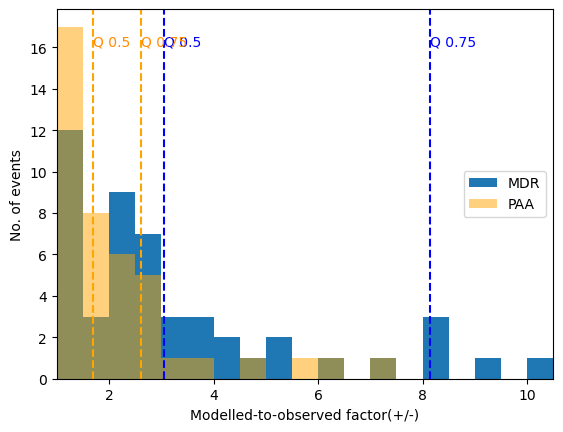

In [ ]:
#Calculate and plot the modelled-to-observed ratio for the crowdsource-based model
_=sc.E.get_mod_obs_ratio(imp_df_crowd,PAA_thresh=100,MDR_thresh=1e5,
                         imp_mod='imp_mod',imp_PAA_mod='n_count_mod')

PAA median factor: 2.5 | MDR median factor: 3.2
PAA 0.75 quantile: 5.0 | MDR 0.75 quantile: 11.6


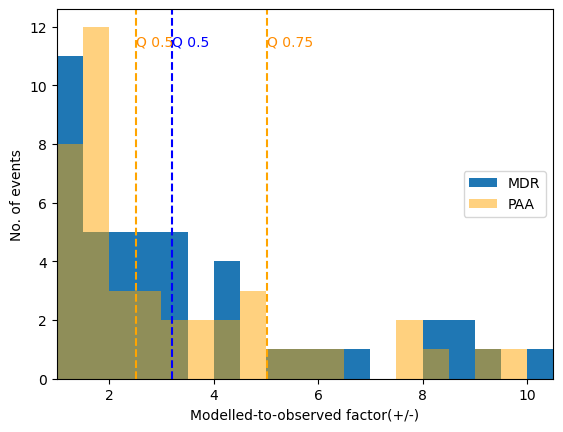

In [ ]:
#Calculate and plot the modelled-to-observed ratio for the MESHS-based model
_=sc.E.get_mod_obs_ratio(imp_df_MESHS,PAA_thresh=100,MDR_thresh=1e5)

PAA median factor: 2.2 | MDR median factor: 4.0
PAA 0.75 quantile: 5.2 | MDR 0.75 quantile: 13.2


Text(0.5, 1.0, 'Crowdsource-based modelled-to-observed ratio per canton')

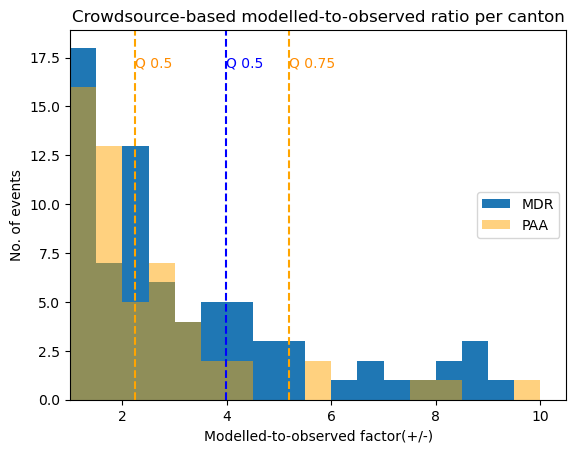

In [69]:
#Ratio per-canton
_=sc.E.get_mod_obs_ratio(imp_df_canton,PAA_thresh=100,MDR_thresh=1e5,imp_mod='imp_crowd',imp_PAA_mod='n_count_crowd')
plt.title("Crowdsource-based modelled-to-observed ratio per canton")

### Example plots

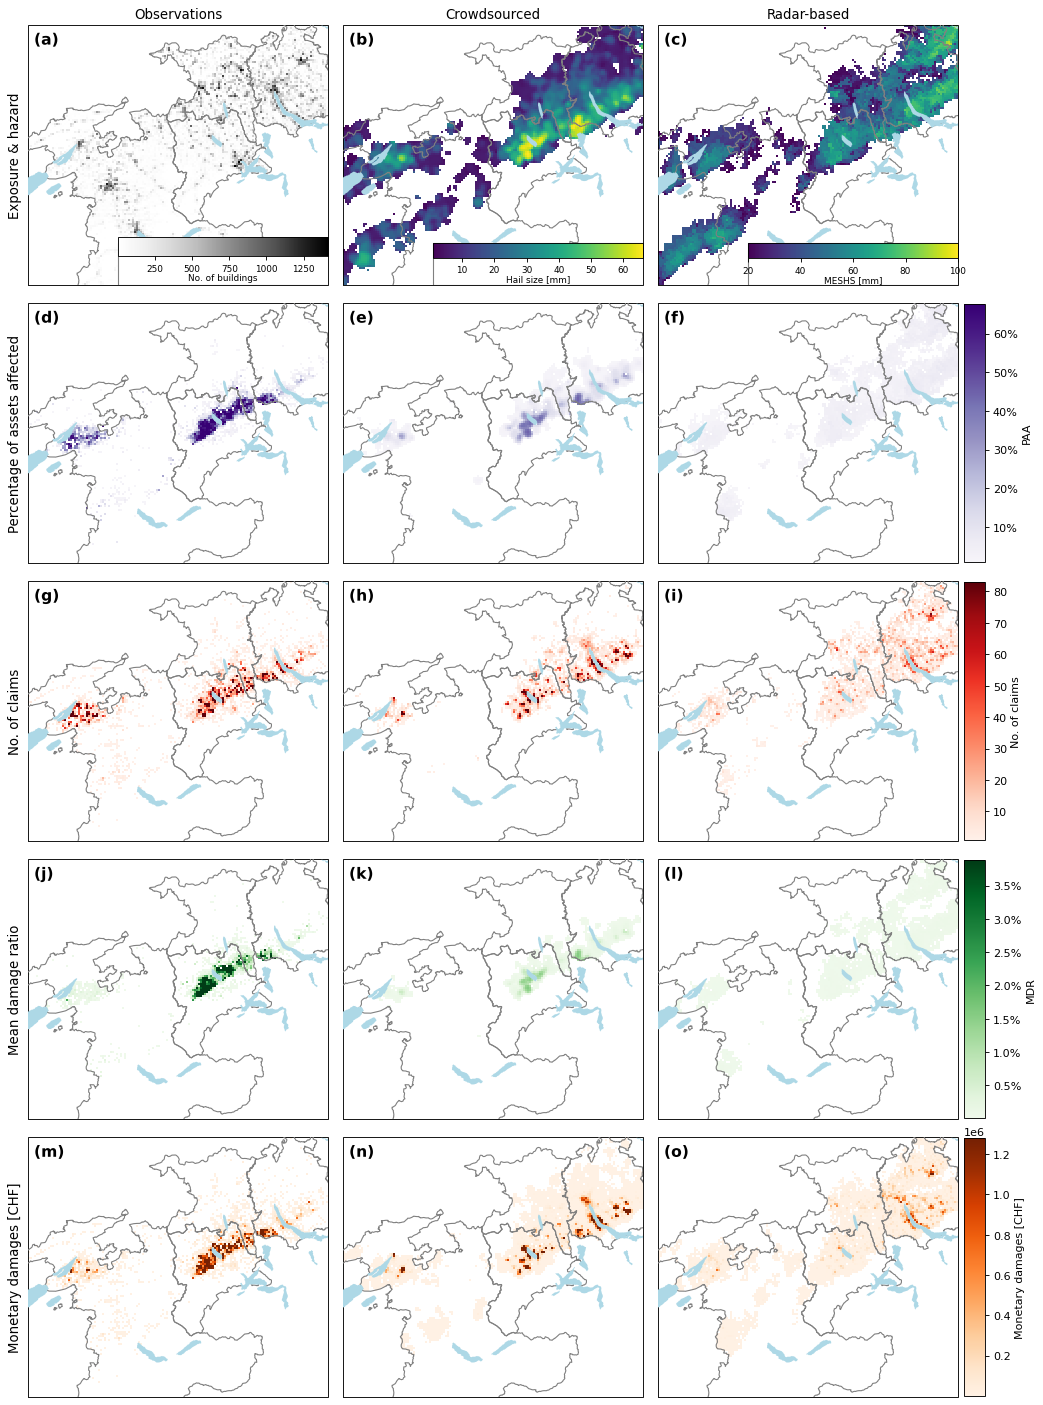

In [34]:
f=sc.plot_funcs.plot_imp_comp_V3('2021-06-28',ds_KGV,ds_haz)
f.savefig(f"{out_dir}/paper_crowd/imp_compar_{'2021-06-28'}.png",dpi=300,bbox_inches='tight')

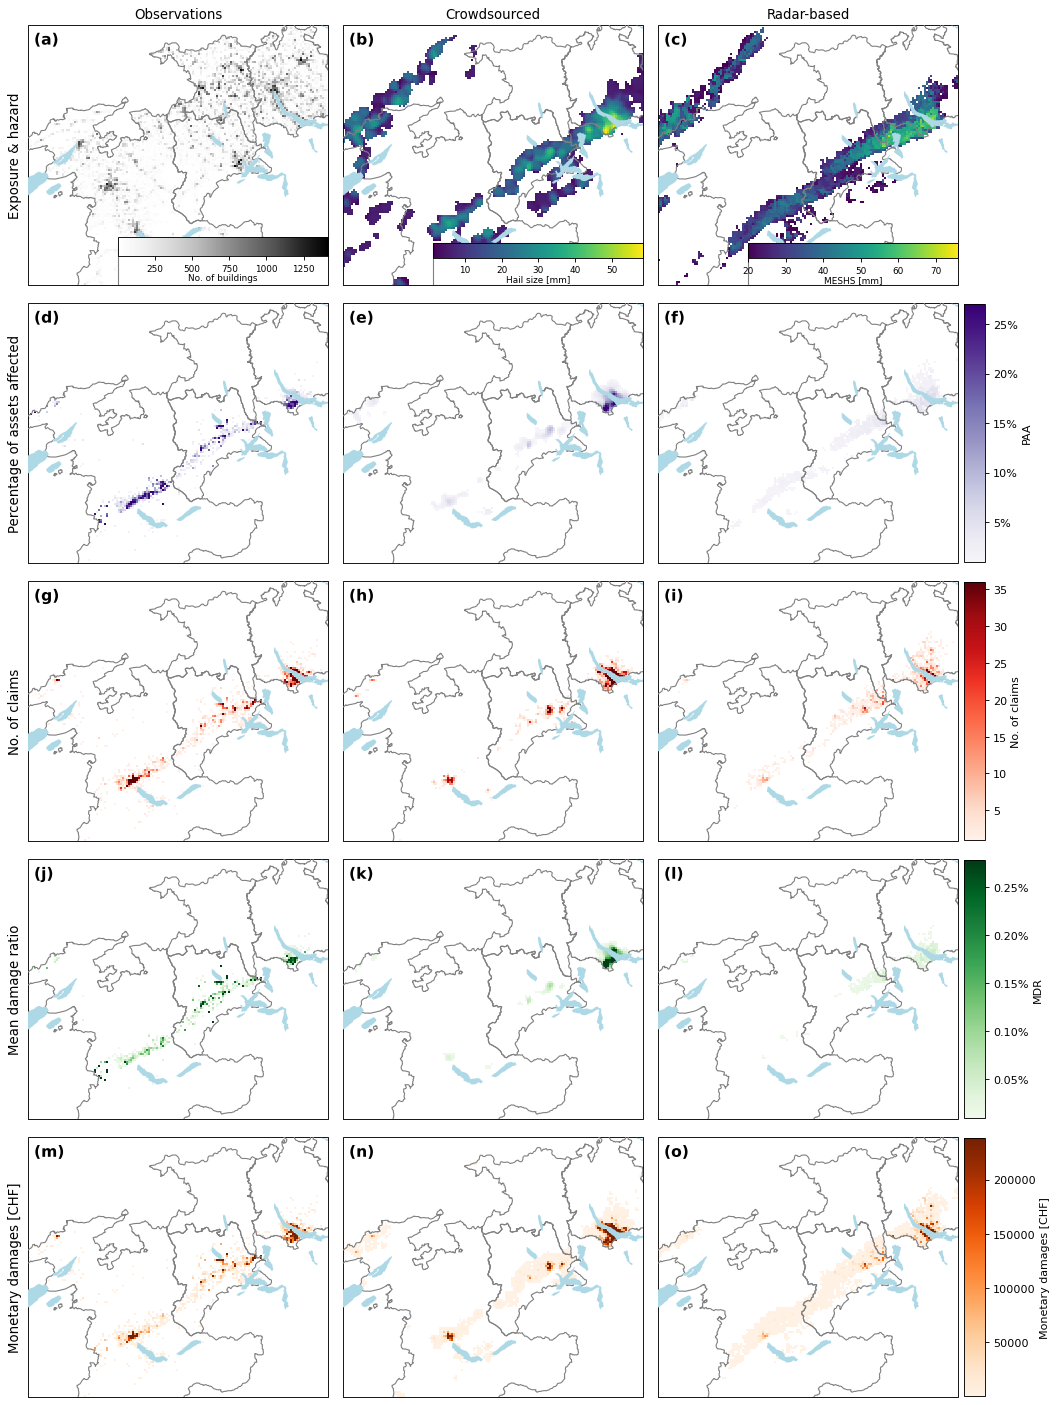

In [35]:
f=sc.plot_funcs.plot_imp_comp_V3('2021-06-21',ds_KGV,ds_haz)
f.savefig(f"{out_dir}/paper_crowd/imp_compar_{'2021-06-21'}.png",dpi=300,bbox_inches='tight')